### Import Relevant Libaries

In [1]:
# Text pre-processing
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
from sklearn.feature_extraction.text import CountVectorizer

# EDA Tools
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import matplotlib.colors as mcolors
from sklearn import preprocessing

# Twitter Crawling Tools
from tweepy import Stream
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
import tweepy
import json

# HTML Crawling Tools
import requests
from bs4 import BeautifulSoup

# Dataframes
import csv
import pandas as pd

# Networks
import networkx as nx
import community

# Word Analytics
from textblob import TextBlob

# Similarity index
import gensim.downloader as api
from gensim.models.keyedvectors import KeyedVectors

# nltk functions
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Twitter API Settings

In [0]:
consumer_key    = 'kkPF5pv3oUP2mKjUngd50Er1C'
consumer_secret = 'pcXCb4wdQtpbiZVgQ8Y8Ve0VZKzC3VkSJTAU8STJkg9IeXqH0e'
access_token    = '373377361-5FjwzwtGtngynNRWlatmY8q1RpxgnQxGrzangJ7l'
access_secret   = 'oJzTNTSy0PhZ3w94cZZOYjqvkY4zOKi1qUZ1hFumPWrrL'

# The following two lines create an authorization object with your above authentication info.
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth,wait_on_rate_limit=True)

### Twitter Functions

In [0]:
class MyListener(StreamListener):
    def on_data(self, data):
        try:
            output_file = csv.writer(open("DFM_Initial_Search_v7.csv", "a", newline=''))
            output_file2 = csv.writer(open("Potential_Influencers_Profiles_v3.csv", "a", newline=''))

            json_data = json.loads(data)
            screen_name = json_data['user']['screen_name']
            user_id = json_data['user']['id']
            text = json_data['text'].replace('\n', ' ').replace('\t', ' ').replace('\b', ' ').lower()
            
            profile = get_profile_info(user_id)
            if profile != {}:
                output_file.writerow([screen_name.lower().strip(),text.encode("utf-8")])
                output_file2.writerow([profile['id'], profile['name'], profile['screen_name'].lower(), profile['location'], profile['description'], profile['url'], profile['followers_count'], profile['friends_count'], profile['listed_count'], profile['created_at'], profile['statuses_count']])
           
            return True
        except BaseException as e:
            print("Error on_data: %s" % str(e))
        return True

    def on_error(self, status):
        print(status)
        return True
    
def get_profile_info(user):
    try:
        user_id = api.get_user(user)
        description = user_id._json
        return description
    except:
        return {}

### Text Pre-Processing Functions

In [0]:
def lemmatize_text(text):
    w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
    lemmatizer = nltk.stem.WordNetLemmatizer()
    token_words = [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]
    return " ".join(token_words)
    
def clean_text(df,column_name):
    # Clean text
    df['cleaned_text'] = df[column_name].str.replace('\S*@\S*\s?',"",regex=True)
    df['cleaned_text'] = df['cleaned_text'].str.replace(r'[^A-Za-z0-9\s]', '')

    #str_to_lower
    df['cleaned_text'] = df["cleaned_text"].map(lambda x: x if type(x)!=str else x.lower())

    #removing punctuations
    df['cleaned_text'] = df['cleaned_text'].str.replace('[^\w\s]','')

    #removing digits
    df['cleaned_text'] = df['cleaned_text'].str.replace('\d+', '')

    #removing stopwords 

    stop = stopwords.words('english')
    df['cleaned_text'] = df['cleaned_text'].astype('str')
    df['cleaned_text'] = df['cleaned_text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))


    # st = PorterStemmer()
    # df['cleaned_text'].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))

    #lemmatizing in name and description

    w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
    lemmatizer = nltk.stem.WordNetLemmatizer()

    df['cleaned_text'] = df['cleaned_text'].apply(lemmatize_text)
    df.head()

    return df

### Network Functions

In [0]:
def network_visualization(G,name):
    closeness_centrality = nx.closeness_centrality(G)

    d = nx.degree(G)

    d = [(d[node]) for node in G.nodes()]
    pos = nx.spring_layout(G, k=0.99*1/np.sqrt(len(G.nodes())), iterations=30)
    plt.figure(figsize=(100, 100))
    nodes = nx.draw_networkx_nodes(G, pos=pos,node_size=[v * 500 for v in d],cmap=plt.cm.RdYlBu, 
                                       node_color=list(closeness_centrality.values()),
                                       nodelist=list(closeness_centrality.keys()))

    # labels = nx.draw_networkx_labels(G, pos)
    edges = nx.draw_networkx_edges(G, pos)

    labels = nx.draw_networkx_labels(G, pos=pos)
    plt.colorbar(nodes,fraction=0.046, pad=0.04)
    plt.axis('off')
    plt.title(name, fontsize=54)
    plt.savefig(name + '.png')
    plt.show()
    
def connected_graph(G):
    if (nx.is_connected(G)):
        print("Network is connected")
    else:
        print("Network is not connected")


def centralization(G):
    N=G.order()
    indegrees = G.degree()
    max_in = None
    total = 0
    for degree in indegrees:
        total += degree[1]
        if max_in == None:
            max_in = degree[1]
        elif degree[1] > max_in:
            max_in = degree[1]
    centralization = float((N*max_in - total))/(N-1)**2
    return centralization

def partition_visualization(G,name):
    partition = community.best_partition(G)  

    d = nx.degree(G)

    d = [(d[node]) for node in G.nodes()]
    pos = nx.spring_layout(G, k=0.99*1/np.sqrt(len(G.nodes())), iterations=30)
    plt.figure(figsize=(50, 50))
    
    nodes = nx.draw_networkx_nodes(G, pos=pos,node_size=[v * 500 for v in d], 
                                       cmap=plt.cm.RdYlBu, node_color=list(partition.values()))

    edges = nx.draw_networkx_edges(G, pos,alpha=0.3)

    # labels = nx.draw_networkx_labels(G, pos=pos)
    plt.colorbar(nodes,fraction=0.046, pad=0.04)
    plt.axis('off')
    plt.title(name, fontsize=36)
    plt.savefig(name + '.png')
    plt.show(G)

def partition_distribution(G,pairwise_df):
    output_file = csv.writer(open("network_v12.csv", "w+", newline=''))
    output_file.writerow(['partition','node','degree centrality','closeness centrality','betweenness centrality','eigenvector centrality','harmonic centrality','total centrality score'])
    
    output_file_2 = csv.writer(open("network_info_v12.csv", "w+", newline=''))
    output_file_2.writerow(['partition','screen_name','to_user'])
    
    partitions = community.best_partition(G)
    count = 0
    harmonic_centrality = nx.harmonic_centrality(G, distance='distance')
    eigenvector_centrality = nx.eigenvector_centrality(G, weight='weight',max_iter=1000)
    betweenness_centrality = nx.betweenness_centrality(G,normalized=True, weight='weight')
    closeness_centrality = nx.closeness_centrality(G, distance='distance')
    number_nodes = pairwise_df['weight'].sum()
    degree_centrality = {}
    for pair in G.degree(weight='weight'):
        degree_centrality[pair[0]] = pair[1]/number_nodes
    network_size = G.size()
    partition_dict = {}
    for node,partition in partitions.items():
        normalized_harmonic = harmonic_centrality[node]/network_size
        total_score = degree_centrality[node] + closeness_centrality[node] + betweenness_centrality[node] + normalized_harmonic+ eigenvector_centrality[node]
        # total_score = 0.15*degree_centrality[node] + 0.1*closeness_centrality[node] + 0.25*betweenness_centrality[node] + 0.15*normalized_harmonic+ 0.20*eigenvector_centrality[node] + 0.15*page_rank[node]
        output_file.writerow([partition, node, degree_centrality[node], closeness_centrality[node],betweenness_centrality[node],eigenvector_centrality[node],normalized_harmonic,total_score])
        if partition not in partition_dict:
            partition_dict[partition] = [node]
        else:
            partition_dict[partition].append(node)

### Crawl Data for Initial Search to store Tweets & User's Profile

In [0]:
# output_file = csv.writer(open("DFM_Initial_Search_v7.csv", "a", newline=''))
# output_file2 = csv.writer(open("Potential_Influencers_Profiles_v3.csv", "a", newline=''))

# output_file.writerow(["screen_name", "text"])
# output_file2.writerow(['id', 'name', 'screen_name', 'location', 'description', 'url', 'followers_count', 'friends_count', 'listed_count', 'created_at', 'statuses_count'])

In [0]:
query_terms = ['hybrid model','hybrid car','hybrid suv','hybrid series','electric car',
'electric suv','concept car','new hybrid series','hybrid concept','electric car concept',
'mercedes series','mercedes model','mercedes SUV','mercedes-benz series','mercedes-benz model',
'mercedes-benz SUV']

keywords = []

for words in query_terms:
    words = words.split()
    for word in words:
        if word not in keywords:
            keywords.append(word)

# twitter_stream = Stream(auth, MyListener())

# twitter_stream.filter(track=query_terms,languages=['en'])

### Read Text file which contains initial search & drop duplicates

In [8]:
combined_df = pd.read_csv('DFM_Initial_Search_v7.csv')
print("Before dropping duplicates and null:", len(combined_df))
combined_df.drop_duplicates(keep='first', inplace=True)
combined_df = combined_df[pd.notnull(combined_df['text'])]
print("After dropping duplicates and null:", len(combined_df))
# combined_df.head(1000000)
combined_df['text'] = combined_df['text'].str[2:].str.replace('\n', ' ').str.replace('\t', ' ').str.lower().str.strip()
filtered_df = combined_df.copy()
filtered_df = filtered_df[filtered_df['text'].str.contains('rt @')]
filtered_df['to_user'] = filtered_df['text'].str.split().str[1].str.replace("@","").str.replace(":","")
filtered_df = filtered_df.copy()
filtered_df.drop(filtered_df.loc[filtered_df['screen_name']==filtered_df['to_user']].index, inplace=True)
                            
print("Only tweets with RTs:", len(filtered_df))

# missing_user = list(filtered_df['to_user'])
# missing_text = list(filtered_df['text'])
# current_user = list(combined_df['screen_name'])
# df = pd.DataFrame(columns=['screen_name','text'])
# count = 0
# for i in range(len(missing_user)):
#     if missing_user[i] not in current_user:
#         text = missing_text[i]
#         text = text.split()
#         new_text = ''
#         for token in text[2:]:
#             new_text += token + ' '
#         new_text = new_text.strip()
#         df.loc[count] = [missing_user[i],new_text]
#         count += 1
# df.to_csv('missing_user.csv',index=False)
# filtered_df.head(1000000)
# filtered_df.to_csv('Influencers_Tweets.csv',index=False)
# filtered_df = pd.read_csv('Influencers_Tweets.csv')
pairwise_df = filtered_df.groupby(['screen_name','to_user']).size().reset_index(name='weight')
pairwise_df = pairwise_df.groupby(['screen_name','to_user'])['weight'].agg('sum').reset_index(name='weight')
pairwise_df['distance'] = 1/pairwise_df['weight']
filtered_df = combined_df
filtered_df = clean_text(filtered_df,'text')

Before dropping duplicates and null: 6888
After dropping duplicates and null: 4521
Only tweets with RTs: 2372


### Crawl Profile info for to_user column

In [0]:
# potential_influencer_df = pd.read_csv('Potential_Influencers_Profiles_v3.csv',encoding = "ISO-8859-1")
# potential_influencer_df.drop_duplicates(subset='screen_name',keep='first', inplace=True)
# for user in list(set(list(filtered_df['to_user']))):
#     if user not in list(potential_influencer_df['screen_name']):
#         profile = get_profile_info(user)
#         if profile != {}:
#             output_file2 = csv.writer(open("Potential_Influencers_Profiles_v3.csv", "a", newline=''))
#             output_file2.writerow([profile['id'], profile['name'], profile['screen_name'].lower(), profile['location'], profile['description'], profile['url'], profile['followers_count'], profile['friends_count'], profile['listed_count'], profile['created_at'], profile['statuses_count']])

The team did some text-preprocessing and inputted the data in preparation to generate the graphs.

### Create Graph & include users who have no RTs

In [0]:
users = list(combined_df['screen_name'])
isolates = []
for user in users:
    if user not in pairwise_df['screen_name'] and user not in pairwise_df['to_user']:
        isolates.append(user)

G = nx.from_pandas_edgelist(pairwise_df, source='screen_name', target='to_user', edge_attr='weight')
G.add_nodes_from(isolates)


### Exploratory Data Analysis

In [11]:
print(nx.info(G),'\n')

connected_graph(G)
print("Number of connected components:",nx.number_connected_components(G))
largest_cc = len(list(max(nx.connected_components(G), key=len)))
network_size = len(G.nodes())
print("Number of users in largest component:",largest_cc,'/',network_size, "("+str(round(largest_cc/network_size*100,3))+"%)")

Name: 
Type: Graph
Number of nodes: 3971
Number of edges: 2325
Average degree:   1.1710 

Network is not connected
Number of connected components: 1725
Number of users in largest component: 546 / 3971 (13.75%)


### Network Visualization

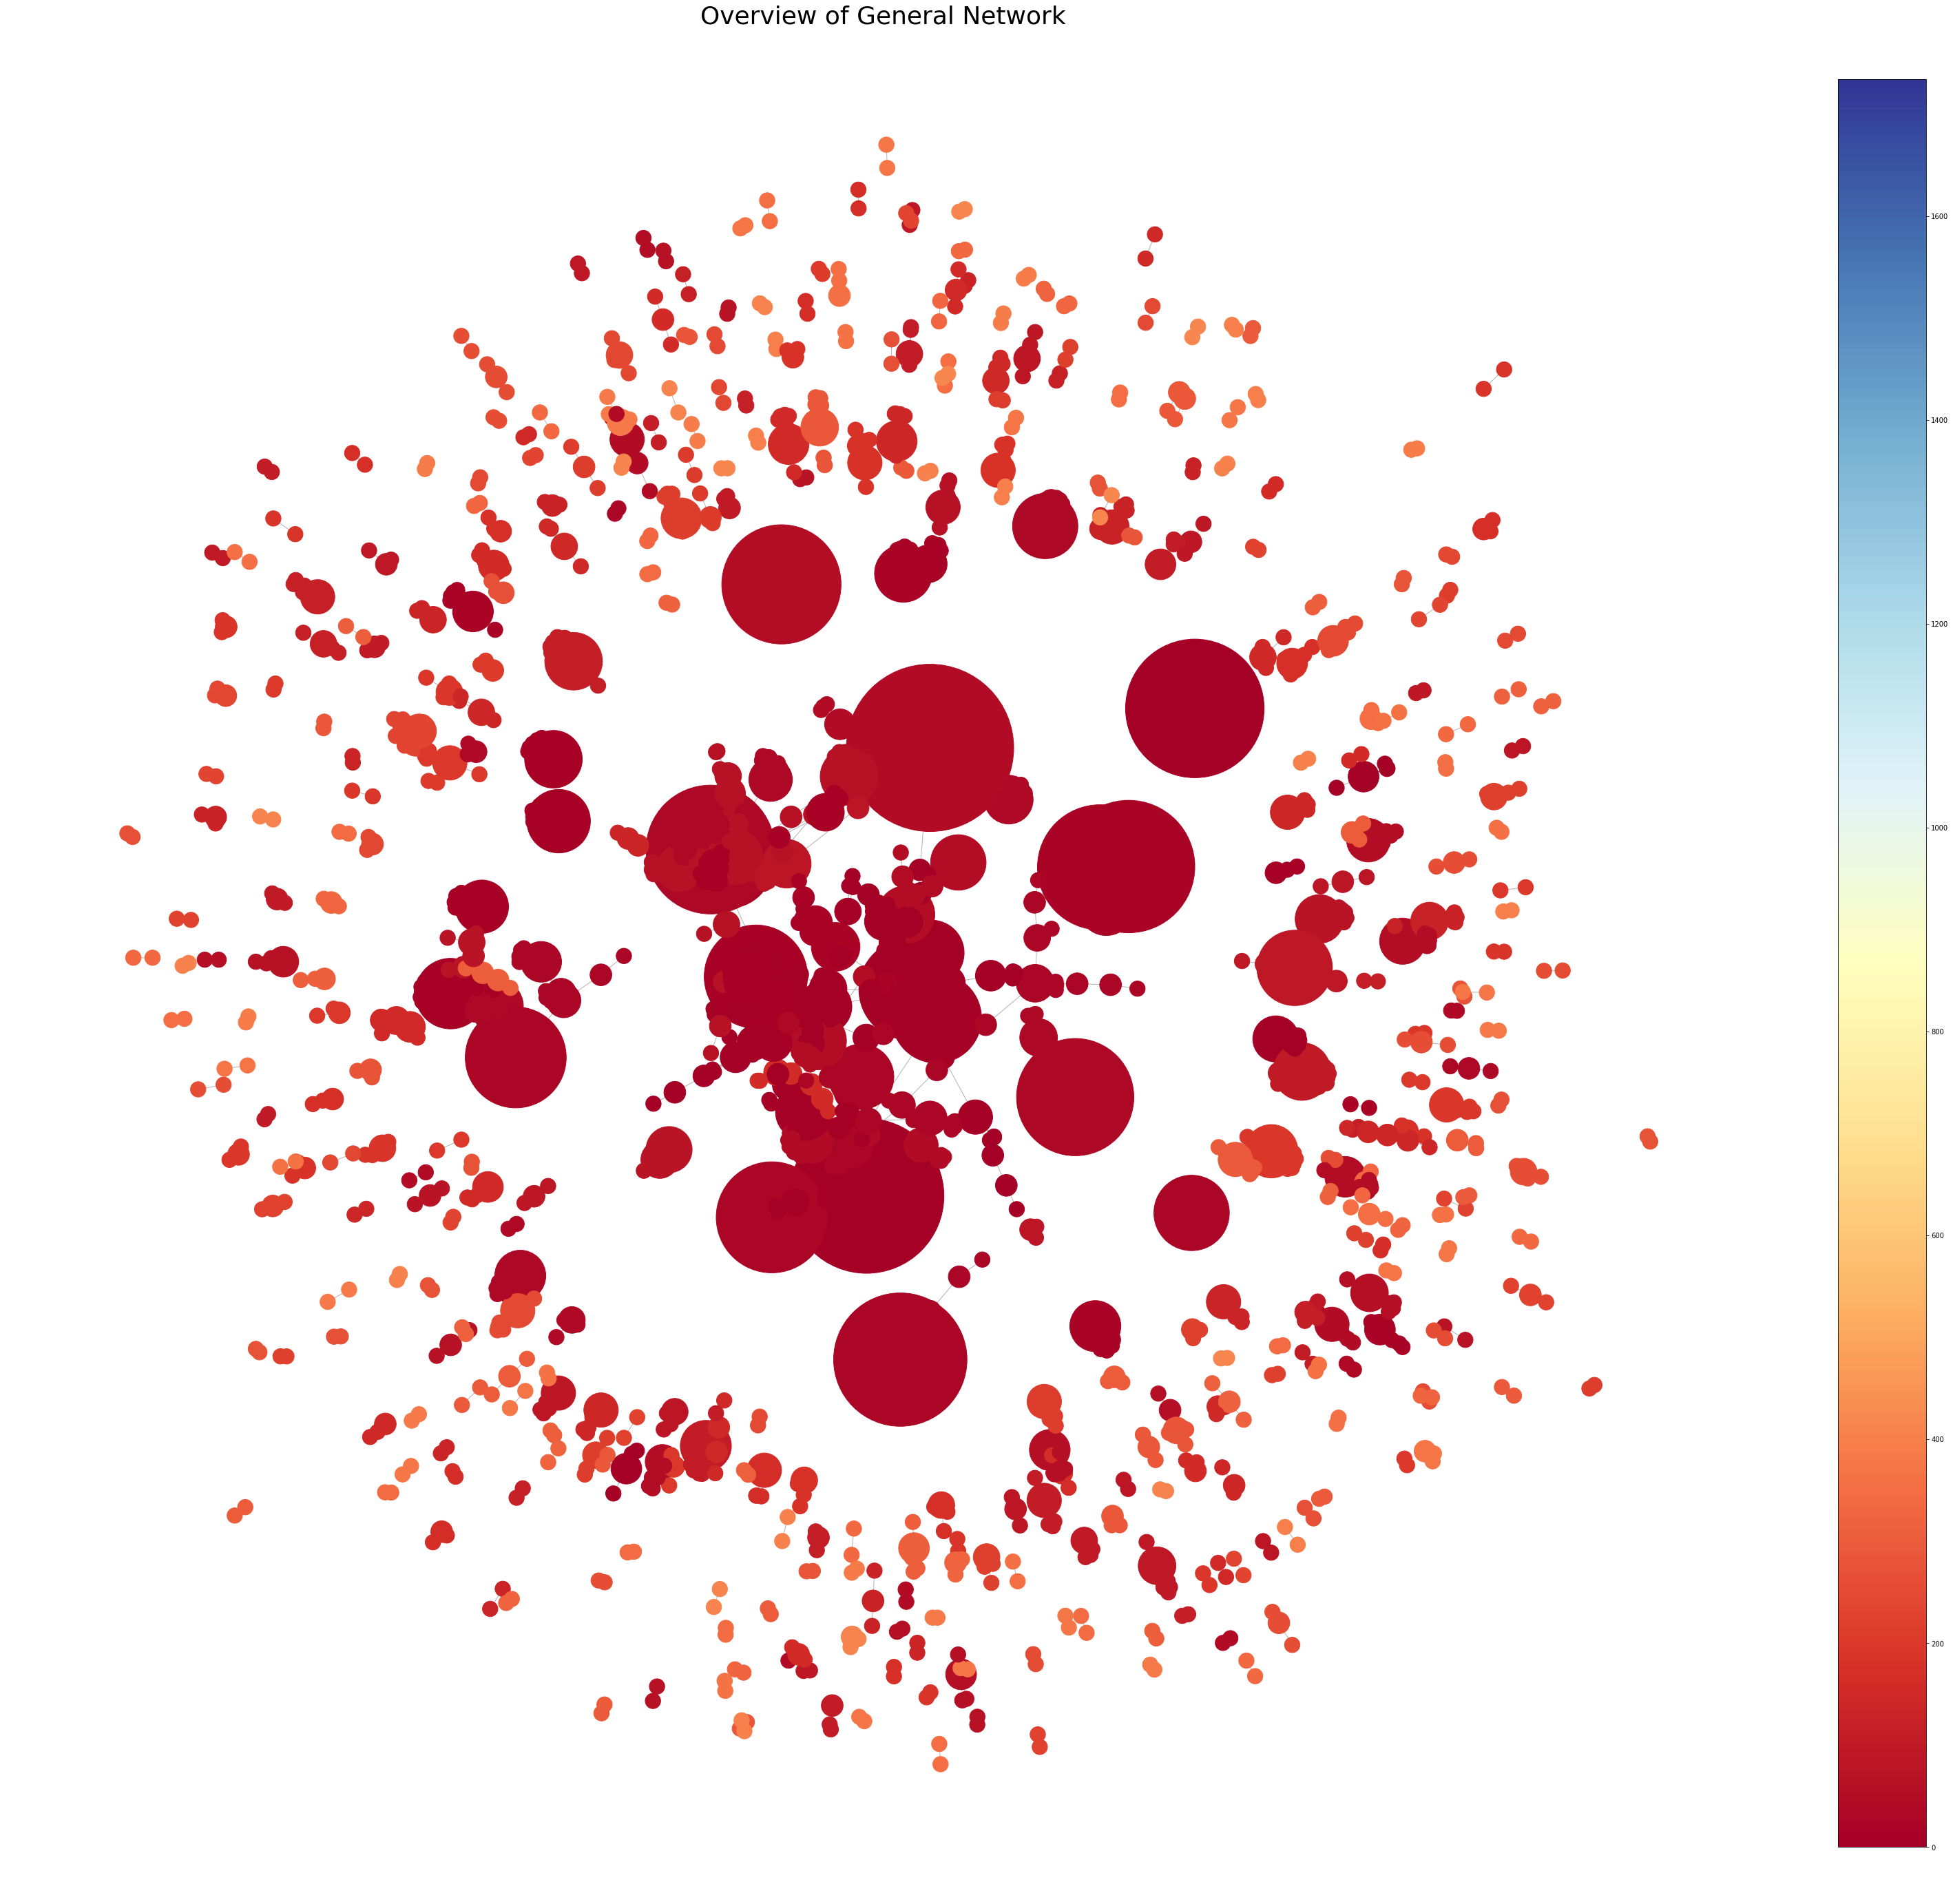

In [12]:
partition_visualization(G,'Overview of General Network')

### Using Community Detection and calculating centrality

In [0]:
partition_distribution(G,pairwise_df)
new_subgraph_df = pd.read_csv('network_v12.csv',encoding = "ISO-8859-1")
mm_scaler = preprocessing.MinMaxScaler()
new_subgraph_df[['total centrality score']] = mm_scaler.fit_transform(new_subgraph_df[['total centrality score']])

### Read CSV file & calculate community metrics

In [14]:
new_subgraph_df = pd.read_csv('network_v12.csv',encoding = "ISO-8859-1")
mm_scaler = preprocessing.MinMaxScaler()
new_subgraph_df[['total centrality score']] = mm_scaler.fit_transform(new_subgraph_df[['total centrality score']])
unique_partitions = list(set(list(new_subgraph_df['partition'])))

network_info_df = pd.DataFrame(columns=['partition','density','diameter','centralization','average path length','clustering coefficient','transitivity','network size'])
networks = []
for i in unique_partitions:
    nodes = list(new_subgraph_df[new_subgraph_df['partition'] == i]['node'])
    temp_G = nx.from_pandas_edgelist(pairwise_df[pairwise_df['screen_name'].isin(nodes)], source='screen_name', target='to_user', edge_attr='weight')
    networks.append(temp_G)
    try:
        density = round(nx.density(temp_G),4)
    except:
        density = 0
    try:
        diameter = nx.diameter(temp_G)
    except:
        diameter = 0
    try:
        clustering_coefficient = round(nx.average_clustering(temp_G),4)
    except:
        clustering_coefficient = 0
    try:
        centralization = round(centralization(temp_G),4)
    except:
        centralization = 0
    try:
        average_path_length = nx.average_shortest_path_length(temp_G)
    except:
        average_path_length = 0
    try:
        transitivity = nx.transitivity(temp_G)
    except:
        transitivity = 0
    network_info_df.loc[i] = [i,density,diameter,centralization,average_path_length,clustering_coefficient,transitivity,temp_G.size()]
network_info_df.head()

,partition,density,diameter,centralization,average path length,clustering coefficient,transitivity,network size
0,0.0,0.0192,4.0,0.9609,2.073562,0.0,0.0,103.0
1,1.0,0.0207,12.0,0.0000,4.079634,0.0,0.0,136.0
2,2.0,0.4000,2.0,0.0000,1.600000,0.0,0.0,4.0
3,3.0,0.2000,2.0,0.0000,1.800000,0.0,0.0,9.0
4,4.0,0.0259,12.0,0.0000,5.441975,0.0,0.0,84.0


### Calculate Similarity of Tweets posted

In [15]:
# keywords += ['meeting','clients','connecting','plan','insurance','travel']
model = KeyedVectors.load_word2vec_format('glove.6B.50d.txt', binary=False)

tweet_sim = []

bar = {}
for sent in list(filtered_df['cleaned_text']):
    tokens = sent.split()
    word_count = 0
    avg_sim = 0
    for word in tokens:
        max_sim = 0
        word_count += 1
        if word in keywords:
            if word not in bar:
                bar[word] = 1
            else:
                bar[word] += 1          
        for kword in keywords:
            if word in model.vocab and kword in model.vocab:
                if model.similarity(word,kword) > max_sim:
                    max_sim = model.similarity(word,kword)
                
        avg_sim += max_sim
    try:
        avg_sim /= word_count
    except:
        avg_sim /= 1
    tweet_sim.append(avg_sim)  

filtered_df['tweet_similarity'] =  tweet_sim
standby_df1 = filtered_df[['screen_name','cleaned_text','tweet_similarity']]


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


### Check popularity of keywords

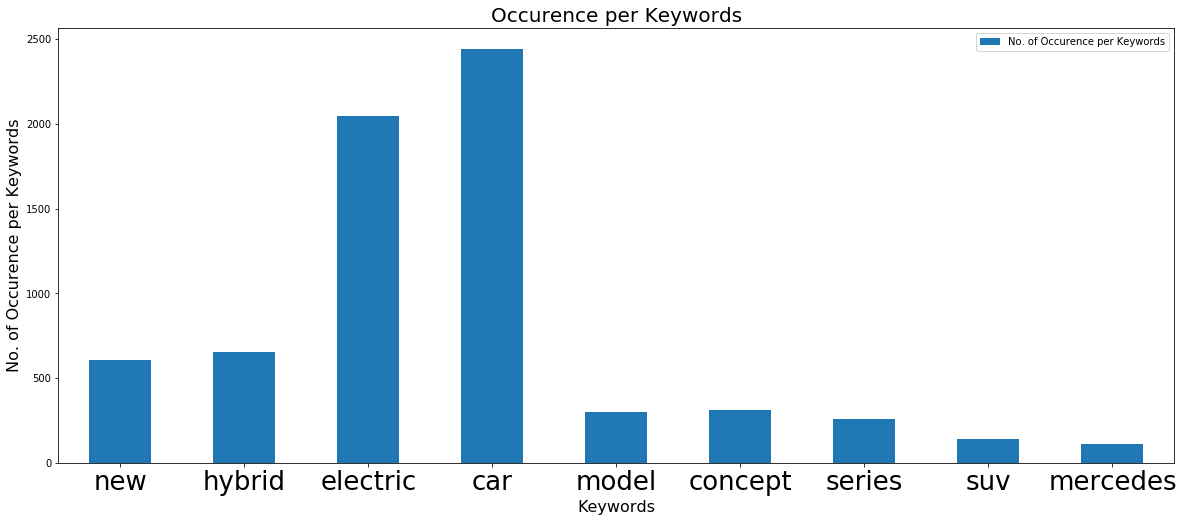

In [16]:
key = bar.keys()
counts = bar.values()
df = pd.DataFrame()
df['keywords'] = key
df['counts'] = counts


fig = plt.figure(figsize=(20, 8))

ax1 = fig.add_subplot(1,1,1)

df.plot(kind='bar', x='keywords', y='counts', ax=ax1)
ax1.set_ylabel("No. of Occurence per Keywords",fontsize=16)
ax1.set_xlabel("Keywords",fontsize=16)
ax1.set_title('Occurence per Keywords',fontsize=20)
ax1.legend(['No. of Occurence per Keywords'])
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0,fontsize=26)
plt.savefig('Keywords.png')

### Calculate Similarity of Profile

In [17]:
potential_influencer_df = pd.read_csv('Potential_Influencers_Profiles_v3.csv',encoding = "ISO-8859-1")
potential_influencer_df.drop_duplicates(subset='screen_name',keep='first', inplace=True)
potential_influencer_df = clean_text(potential_influencer_df,'description')
model = KeyedVectors.load_word2vec_format('glove.6B.50d.txt', binary=False)

profile_sim = []

for sent in list(potential_influencer_df['cleaned_text']):
    try:
        tokens = sent.split()
        word_count = 0
        avg_sim = 0
        for word in tokens:
            max_sim = 0
            word_count += 1
            for kword in keywords:
                if word in model.vocab and kword in model.vocab:
                    if model.similarity(word,kword) > max_sim:
                        max_sim = model.similarity(word,kword)
            avg_sim += max_sim
        avg_sim /= word_count
        profile_sim.append(avg_sim) 
    except:
        profile_sim.append(0)

potential_influencer_df['individual_profile_similarity'] =  profile_sim
standby_df2 = potential_influencer_df[['screen_name','cleaned_text','individual_profile_similarity']]
present_df = standby_df1.merge(standby_df2, how='inner', left_on='screen_name', right_on='screen_name')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [18]:
present_df.columns = ['Twitter Handle','Tweet','Tweet Similarity','Profile','Profile Similarity']
present_df.head()

,Twitter Handle,Tweet,Tweet Similarity,Profile,Profile Similarity
0,cunningman45,rt xfxfxaxawho framed roger rabbit director ro...,0.377286,ever heard random stick figureness good check ...,0.514467
1,auto_futures,question xexdxxexaxa would make buy electric car,0.685985,awardwinning content hub dedicated future mobi...,0.382114
2,tslaluv,rt hater realize taxi turning tesla xfxfxxf ht...,0.379907,man love tesla get httpstcopppfomsl,0.467561
3,pflab,rt tesla model becomes first electric car appr...,0.572082,permanent future lab future evolves everything...,0.435685
4,pflab,rt carmaker survive electric revolution httpst...,0.386384,permanent future lab future evolves everything...,0.435685


### Load New Profile with Similarity score

In [19]:
potential_influencer_df['followers_count'] = potential_influencer_df['followers_count'] + 1
potential_influencer_df['friends_count'] = potential_influencer_df['friends_count'] + 1
potential_influencer_df['follower to following ratio'] = potential_influencer_df['followers_count']/potential_influencer_df['friends_count']

potential_influencer_df.replace([np.inf, -np.inf], np.nan,inplace=True)
potential_influencer_df.fillna(0)

,id,name,screen_name,location,description,url,followers_count,friends_count,listed_count,created_at,statuses_count,Unnamed: 11,Unnamed: 12,Unnamed: 13,cleaned_text,individual_profile_similarity,follower to following ratio
0,9.610000e+17,Auto Futures,auto_futures,"London, England",An award-winning content hub dedicated to the ...,https://t.co/BMId7NpfzQ,845,834,22,Wed Feb 07 10:15:33 +0000 2018,980,0.0,72.0,104.0,awardwinning content hub dedicated future mobi...,0.382114,1.013189
1,1.150000e+18,tslaluv,tslaluv,United States,man I just LOVE my tesla. get yours https://t....,0,145,296,0,Sun Jul 07 08:04:31 +0000 2019,552,0.0,0.0,0.0,man love tesla get httpstcopppfomsl,0.467561,0.489865
2,9.310000e+17,sgfleetUK,sgfleetuk,"Solihull, England",#FleetManagement #VehicleLeasing and #Employee...,https://t.co/tmKw5AKXNM,761,719,8,Wed Nov 15 15:02:15 +0000 2017,927,0.0,0.0,0.0,fleetmanagement vehicleleasing employeebenefit...,0.417369,1.058414
3,1.020000e+18,Samuel Kwakye,mrkwakye_,"Accra, Ghana",Auto enthusiast ...,0,471,482,0,Wed Aug 01 13:34:20 +0000 2018,5384,0.0,0.0,0.0,auto enthusiast,0.551574,0.977178
4,3.001781e+09,DUNKIE TWELVE,dunkiefulldunk1,0,umushabitsi,0,201,97,0,Tue Jan 27 18:36:09 +0000 2015,87,0.0,0.0,0.0,umushabitsi,0.000000,2.072165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6780,1.751814e+07,Red Hat Government,redhatgov,"Tysons Corner, VA",Official updates from Red Hat's Public Sector ...,http://t.co/Fwnj2wRmJO,13220,648,564,Thu Nov 20 18:41:35 +0000 2008,6667,0.0,0.0,0.0,official update red hat public sector team cov...,0.610283,20.401235
6781,1.221884e+08,MACleanEnergyCenter,masscec,Massachusetts,The Massachusetts Clean Energy Center - suppor...,http://t.co/5X2fPDkD95,11075,2358,390,Thu Mar 11 22:08:10 +0000 2010,7683,0.0,0.0,0.0,massachusetts clean energy center supporting m...,0.589899,4.696777
6782,1.700726e+09,Jenny Nicholson @ Halloween,jennyenicholson,"Los Angeles, CA","Video maker, pro gamer, amateur theme park fan...",https://t.co/ChlGmmEvpV,105614,268,302,Mon Aug 26 02:46:59 +0000 2013,16862,0.0,0.0,0.0,video maker pro gamer amateur theme park fan t...,0.538365,394.082090
6783,1.654147e+08,Simon Pickstone,simonpickstone,0,Environmental journalist at @TheENDSReport and...,0,350,1033,5,Sun Jul 11 14:05:53 +0000 2010,417,0.0,0.0,0.0,environmental journalist english editor writes...,0.532239,0.338819


### Calculate Average Profile Similairty Score within their community

In [20]:
profile_similarity_df = potential_influencer_df.groupby(['screen_name'])[['individual_profile_similarity']].mean().reset_index()
profile_similarity_df.columns = ['screen_name','average profile similarity']
profile_similarity_df.head()
final_partition_df = new_subgraph_df.merge(profile_similarity_df, how='inner', left_on='node', right_on='screen_name')
final_partition_df.head()
mm_scaler = preprocessing.MinMaxScaler()
partition_df = final_partition_df.groupby(['partition'])[['average profile similarity']].mean().reset_index()

present_df = partition_df.copy()
present_df.columns = ['Community','Average Profile Similarity']
present_df.head()

,Community,Average Profile Similarity
0,0,0.343829
1,1,0.352376
2,2,0.393304
3,3,0.278607
4,4,0.326197


### Merge all the dataframes into individual df

In [21]:
tweet_similarity_df = filtered_df.groupby(['screen_name'])['tweet_similarity'].mean().reset_index(name='average tweet similarity')
final_user_df = new_subgraph_df.merge(tweet_similarity_df, how='inner', left_on='node', right_on='screen_name')
final_user_df = final_user_df.merge(potential_influencer_df[['screen_name','follower to following ratio','individual_profile_similarity']], how='inner', left_on='node', right_on='screen_name')
del final_user_df['screen_name_x']
del final_user_df['screen_name_y']
final_user_df.head()
network_info_df = network_info_df.merge(partition_df,how='inner',left_on='partition', right_on='partition')
mm_scaler = preprocessing.MinMaxScaler()
network_info_df[['diameter','average path length']] = mm_scaler.fit_transform(network_info_df[['diameter','average path length']])
final_user_df[['follower to following ratio']] = mm_scaler.fit_transform(final_user_df[['follower to following ratio']])
final_user_df.head()

,partition,node,degree centrality,closeness centrality,betweenness centrality,eigenvector centrality,harmonic centrality,total centrality score,average tweet similarity,follower to following ratio,individual_profile_similarity
0,0,007__goldeneye,0.000422,0.015509,0.000000,1.953196e-07,0.030444,0.072187,0.443952,0.000007,0.480390
1,0,getfandom,0.042580,0.023371,0.001699,1.963350e-06,0.054760,0.190546,0.335673,0.000073,0.522711
2,1,00_hkm,0.000422,0.023572,0.000000,1.411059e-06,0.046964,0.110454,0.561350,0.000007,0.212523
3,1,volkswagen,0.016863,0.028448,0.008418,1.533889e-05,0.063892,0.183112,0.534955,0.009192,0.384320
4,0,1031cookielover,0.000422,0.015509,0.000000,1.953196e-07,0.030444,0.072187,0.443952,0.000001,0.332635


### Overview of network's metrics

In [22]:
network_info_df.describe()
network_info_df['network size ratio'] = network_info_df['network size']/G.size()
network_info_df['total community influence score'] = ((network_info_df['density'] + network_info_df['diameter'] + network_info_df['average path length'] + network_info_df['clustering coefficient'] + network_info_df['transitivity'])) * network_info_df['network size ratio']
network_info_df.head()

,partition,density,diameter,centralization,average path length,clustering coefficient,transitivity,network size,average profile similarity,network size ratio,total community influence score
0,0.0,0.0192,0.333333,0.9609,0.381031,0.0,0.0,103.0,0.343829,0.044301,0.032498
1,1.0,0.0207,1.000000,0.0000,0.749660,0.0,0.0,136.0,0.352376,0.058495,0.103557
2,2.0,0.4000,0.166667,0.0000,0.294011,0.0,0.0,4.0,0.393304,0.001720,0.001481
3,3.0,0.2000,0.166667,0.0000,0.330762,0.0,0.0,9.0,0.278607,0.003871,0.002700
4,4.0,0.0259,1.000000,0.0000,1.000000,0.0,0.0,84.0,0.326197,0.036129,0.073194


In [23]:
final_score_df = final_user_df.merge(partition_df, how='inner', left_on='partition', right_on='partition')
final_score_df = final_user_df.merge(network_info_df, how='inner', left_on='partition', right_on='partition')

for column in ['density','diameter','centralization','average path length','clustering coefficient','transitivity','network size','degree centrality','closeness centrality','betweenness centrality','eigenvector centrality','harmonic centrality','network size ratio']:
    del final_score_df[column]
final_score_df['total similarity score'] = (final_score_df['average tweet similarity'] + final_score_df['individual_profile_similarity'] + final_score_df['average profile similarity'])
final_score_df['total influence score'] = (final_score_df['total centrality score'] + final_score_df['follower to following ratio'] + final_score_df['total community influence score'])
final_score_df[['total similarity score','total influence score']] = mm_scaler.fit_transform(final_score_df[['total similarity score','total influence score']])
final_score_df['total value of user'] = final_score_df['total similarity score'] * 0.75 + final_score_df['total influence score'] * 0.25
for column in ['average tweet similarity','average profile similarity','total centrality score','follower to following ratio','individual_profile_similarity','total community influence score']:
    del final_score_df[column]
final_score_df.columns = ['Community','Twitter Handle','Similarity Score','Influence Score','Total Score']
final_score_df = final_score_df.sort_values(by='Total Score', ascending=False).reset_index()
del final_score_df['index']
final_score_df.to_csv('Final_List(Twitter).csv',index=False)
final_score_df.head(10)

,Community,Twitter Handle,Similarity Score,Influence Score,Total Score
0,1146,newcars19,1.000000,0.000041,0.750010
1,1118,myelectriccari1,0.921899,0.000005,0.691426
2,1441,cjose293,0.885628,0.000011,0.664224
3,546,caacarcom,0.877097,0.000015,0.657827
4,1466,u_cedd_what,0.863502,0.000036,0.647635
5,902,cnsinotruk,0.820640,0.000002,0.615480
6,228,kiamotorsin,0.499869,0.950583,0.612548
7,1076,reubenletlhaka1,0.816467,0.000004,0.612352
8,1631,maostrega,0.810122,0.000009,0.607594
9,659,anaconthebeat,0.808200,0.000055,0.606164


In [24]:
display(final_score_df[final_score_df['Twitter Handle'] == 'assaadrazzouk'])
display(final_score_df[final_score_df['Community'] == 254]['Total Score'].max())
potential_influencer_df[potential_influencer_df['screen_name'] == 'evexplain'].head()

,Community,Twitter Handle,Similarity Score,Influence Score,Total Score
2317,254,assaadrazzouk,0.477692,0.002275,0.358838


0.35883785955862846

,id,name,screen_name,location,description,url,followers_count,friends_count,listed_count,created_at,statuses_count,Unnamed: 11,Unnamed: 12,Unnamed: 13,cleaned_text,individual_profile_similarity,follower to following ratio
6502,9.190000e+17,EV explain ððð,evexplain,UK,"Hi it's Thomas, some useful info (I hope) & ne...",https://t.co/v7Vy8VlN4p,133,1,3,Fri Oct 13 14:10:31 +0000 2017,1989,NaN,NaN,NaN,hi thomas useful info hope news ev driver ride...,0.532975,133.0


### EDA

In [ ]:
backup_score_df = final_score_df.copy()
for column in ['partition']:
    del backup_score_df[column]
stats_df = backup_score_df.describe().transpose()
del stats_df['count']
stats_df['IQR'] = stats_df['75%'] - stats_df['25%']
stats_df['<25%'] = stats_df['25%'] - 1.5* stats_df['IQR']
stats_df['>75%'] = stats_df['75%'] + 1.5* stats_df['IQR']
stats_df.head(10000)

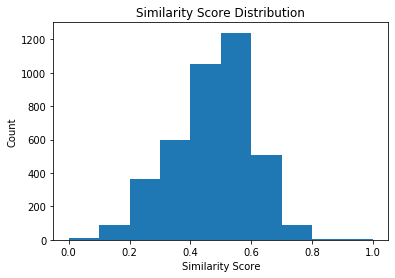

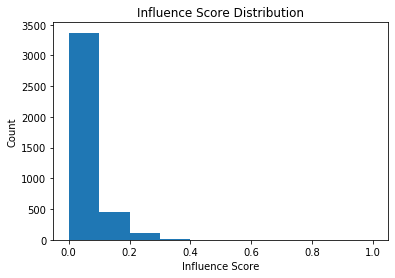

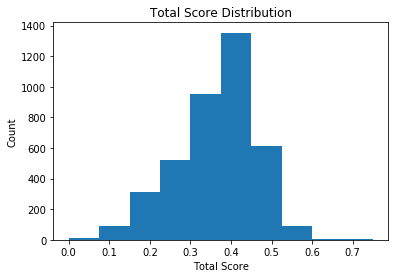

In [6]:
final_score_df = pd.read_csv("Final_List(Twitter).csv")
for column in ['Similarity Score','Influence Score','Total Score']:
    ax = final_score_df[column].plot(
        kind='hist',
        title=column+' Distribution')
    ax.set_xlabel(column)
    ax.set_ylabel("Count")
    plt.show()